In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

<hr/>

## Exploration
Let us take a first look at the data

In [2]:
dataset = pd.read_csv(f'data/chess.csv')
copy = dataset.copy() # Working on a copy keeps us from changing anything important
dataset.describe()

,created_at,last_move_at,turns,white_rating,black_rating,opening_ply
count,2.005800e+04,2.005800e+04,20058.000000,20058.000000,20058.000000,20058.000000
mean,1.483617e+12,1.483618e+12,60.465999,1596.631868,1588.831987,4.816981
std,2.850151e+10,2.850140e+10,33.570585,291.253376,291.036126,2.797152
min,1.376772e+12,1.376772e+12,1.000000,784.000000,789.000000,1.000000
25%,1.477548e+12,1.477548e+12,37.000000,1398.000000,1391.000000,3.000000
50%,1.496010e+12,1.496010e+12,55.000000,1567.000000,1562.000000,4.000000
75%,1.503170e+12,1.503170e+12,79.000000,1793.000000,1784.000000,6.000000
max,1.504493e+12,1.504494e+12,349.000000,2700.000000,2723.000000,28.000000


In [3]:
dataset.nunique()

id                19113
rated                 2
created_at        13151
last_move_at      13186
turns               211
victory_status        4
winner                3
increment_code      400
white_id           9438
white_rating       1516
black_id           9331
black_rating       1521
moves             18920
opening_eco         365
opening_name       1477
opening_ply          23
dtype: int64

There are no missing values. We do however need to take a look at some of the columns to see if we can turn them into good features

<hr/>

## Ratings
Let us check the distribution of ratings and the distribution of the rating difference.

In [4]:
rating_data = np.concatenate((dataset['white_rating'].values.reshape(-1,1), 
    dataset['black_rating'].values.reshape(-1,1), 
    dataset['white_rating'].values.reshape(-1,1)-dataset['black_rating'].values.reshape(-1,1)), axis=1)
rating = pd.DataFrame(data = rating_data, columns=['white', 'black', 'diff'])
rating.describe()

,white,black,diff
count,20058.000000,20058.000000,20058.000000
mean,1596.631868,1588.831987,7.799880
std,291.253376,291.036126,249.036667
min,784.000000,789.000000,-1605.000000
25%,1398.000000,1391.000000,-108.000000
50%,1567.000000,1562.000000,3.000000
75%,1793.000000,1784.000000,122.000000
max,2700.000000,2723.000000,1499.000000


Text(0.5, 1.0, 'Rating Difference in each game')

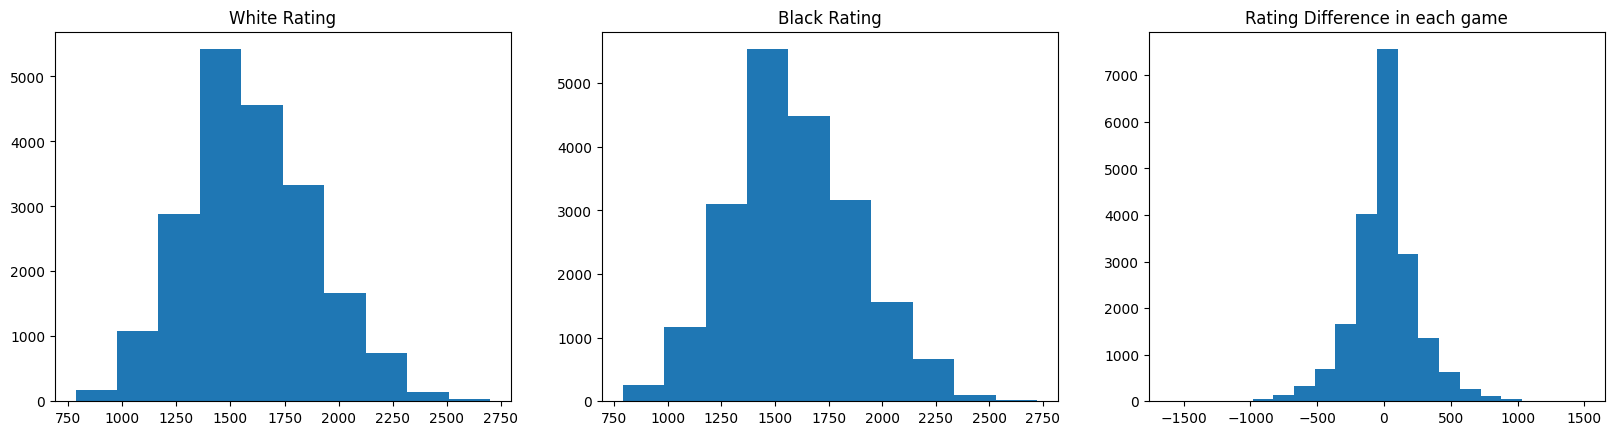

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figwidth(20)
ax1.hist(rating['white'])
ax1.set_title('White Rating')
ax2.hist(rating['black'])
ax2.set_title('Black Rating')
ax3.hist(rating['diff'], bins=20)
ax3.set_title('Rating Difference in each game')

From these data, we see that a large panel of ratings is represented and the difference also have a significant variance. It is therefore interesting to try to estimate one rating while knowing the other. If ratings were basically always the same, the prediction would be trivial.

<hr/>

## Opening name
There are too many different openings, but we try to see if it can be a good feature

In [6]:
dataset['opening_name'].value_counts()

Van't Kruijs Opening                                              368
Sicilian Defense                                                  358
Sicilian Defense: Bowdler Attack                                  296
Scotch Game                                                       271
French Defense: Knight Variation                                  271
                                                                 ... 
Sicilian Defense: Kupreichik Variation                              1
Modern Defense: Lizard Defense |  Mittenberger Gambit               1
French Defense: Rubinstein Variation |  Kasparov Attack             1
French Defense: Tarrasch Variation |  Open System |  Main Line      1
Sicilian Defense: Najdorf Variation |  Polugaevsky Variation        1
Name: opening_name, Length: 1477, dtype: int64

In [7]:
# We try to simplify the opening names by getting rid of the variations (e.g. "French defense #2 : Advanced variation" -> "French defense")
copy['opening_name'] = copy['opening_name'].str.extract(r'(^[^\|\:\#]+)')
# We count how many times each opening appears
count_openings = copy['opening_name'].value_counts()
# We keep only the opening that appear more than 100 times
usual_openings = count_openings.index[count_openings.values >=100]

In [8]:
# If we want to replace the unusual openings by "Other"
copy['opening_name'] = np.where(copy['opening_name'].isin(usual_openings).values, copy['opening_name'].values, 'Other')

In [9]:
copy['opening_name'].value_counts()

Other                      2598
Sicilian Defense           2573
French Defense             1306
Queen's Pawn Game          1059
Italian Game                981
King's Pawn Game            917
Ruy Lopez                   858
English Opening             720
Scandinavian Defense        716
Caro-Kann Defense           593
Scotch Game                 465
Philidor Defense            419
Queen's Gambit Declined     394
Four Knights Game           370
Van't Kruijs Opening        368
Zukertort Opening           336
Bishop's Opening            323
Indian Game                 319
Philidor Defense            272
Queen's Gambit Accepted     253
Russian Game                252
Queen's Gambit Refused      251
Modern Defense              225
Horwitz Defense             209
Nimzowitsch Defense         200
King's Indian Defense       197
Pirc Defense                193
Alekhine Defense            188
Slav Defense                187
King's Knight Opening       183
Hungarian Opening           179
Queen's 

It is still unsure whether creating many categories for the opening_name is worth it for the model

<hr/>

## Increment Code
This categorical variable is at the moment unusable, we have to simplify it. (atm 400 unique values).<br>
We will extract the game formats 'bullet', 'blitz', 'rapid', and 'long'

In [10]:
copy['increment_code'] = copy['increment_code'].str.extract(r'(^[^\+\s]+)')
copy['increment_code'] = pd.to_numeric(copy['increment_code'])
copy.describe()

,created_at,last_move_at,turns,increment_code,white_rating,black_rating,opening_ply
count,2.005800e+04,2.005800e+04,20058.000000,20058.000000,20058.000000,20058.000000,20058.000000
mean,1.483617e+12,1.483618e+12,60.465999,13.824110,1596.631868,1588.831987,4.816981
std,2.850151e+10,2.850140e+10,33.570585,17.160179,291.253376,291.036126,2.797152
min,1.376772e+12,1.376772e+12,1.000000,0.000000,784.000000,789.000000,1.000000
25%,1.477548e+12,1.477548e+12,37.000000,10.000000,1398.000000,1391.000000,3.000000
50%,1.496010e+12,1.496010e+12,55.000000,10.000000,1567.000000,1562.000000,4.000000
75%,1.503170e+12,1.503170e+12,79.000000,15.000000,1793.000000,1784.000000,6.000000
max,1.504493e+12,1.504494e+12,349.000000,180.000000,2700.000000,2723.000000,28.000000


We now convert as follow :
0-2 : bullet, 3-9 : blitz, 10-30 : rapid, >30 : long (based on chess.com notation)

In [11]:
copy['increment_code'] = np.select([copy['increment_code']<=2, copy['increment_code']<=9, copy['increment_code']<=30],
                                   ['bullet', 'blitz', 'rapid'],
                                   default='long')

<hr/>

## Other columns
* The start and end times both are weirdly rounded up which makes them unusable
* The ids obviously are not useful to us
* Opening_eco corresponds to a unique code for each opening, no need to have that and the opening_name
* rated, turns, victory status, winner, and opening_ply are already useable
* moves are useful if we want to determine how many bluders occured. This is, however, too complicated for now.

<hr/>

## Export the modified data
We drop the column that will never be useful and export.

In [15]:
copy = copy.drop(labels=['id', 'white_id', 'black_id', 'opening_eco', 'created_at', 'last_move_at'], axis=1)
copy.to_csv('data/chess_simplified.csv', index=False)